# Imports

In [12]:
from vip_hci.fits import open_fits,write_fits
import numpy as np
from matplotlib import pyplot as plt
from hciplot import plot_frames
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
import vip_hci as vip

In [14]:
vip.__version__

'1.3.1'

In [15]:
#include the files from path ../
import sys
sys.path.append('../CCF_code/')
from CCFcore.PreProcess import SINFONI
from CCFcore.CrossCorr import CrossCorr
from CCFcore import removeTelluric
import multiprocessing
from contextlib import contextmanager
from CCFcore import removeTelluric,applyFilter,measureSpatialSpec
from vip_hci.preproc.cosmetics import frame_center,cube_crop_frames,frame_crop
from vip_hci.preproc.derotation import cube_derotate
from vip_hci.metrics.stim import stim_map
from vip_hci.metrics.snr_source import snrmap
from vip_hci.var.shapes import mask_circle
from vip_hci.metrics.roc import compute_binary_map
from vip_hci.hci_postproc import median_sub
from hciplot import plot_frames
from vip_hci.fm.fakecomp import cube_inject_companions

In [16]:
plt.style.use('seaborn')

# Read in the data and compute ADI median to compare the CCF and STCM

In [25]:
#download the data from this note book or go to the zenoodo records to download it.
#!pip install requests
import requests
# Replace with the URL of the file you want to download
url = 'https://zenodo.org/records/10901109/files/ASDI_cube.fits'

# Send a GET request to the URL
response = requests.get(url)

# Make sure the request was successful
if response.status_code == 200:
    # Write the content of the response to a file
    with open('../data/source/ASDI_cube.fits', 'wb') as file:
        file.write(response.content)

In [17]:
temp_path = "../data/source/"
fl_insert="lte013.0-3.0-0.0a+0.0.BT-Settl.spec.fits.gz"
datapath="../data/source/"
cube = open_fits(datapath+"ASDI_cube.fits")
data_waves= open_fits(datapath+"lbda_vec")
fwhm = open_fits(datapath+"fwhm_vec.fits")
rot_angles = open_fits(datapath+"derot_angles.fits")
psf_template = open_fits(datapath+"PSF_template.fits")


Fits HDU-0 data successfully loaded. Data shape: (2005, 83, 61, 61)
Fits HDU-0 data successfully loaded. Data shape: (2005,)
Fits HDU-0 data successfully loaded. Data shape: (2005,)
Fits HDU-0 data successfully loaded. Data shape: (83,)
Fits HDU-0 data successfully loaded. Data shape: (2005, 13, 13)


In [19]:
vels=np.linspace(-100,100,20)
CC=CrossCorr(vels)
temp_flux,temp_waves=CC.processTemplate(temp_path+fl_insert)
contrast = 1e-03
rad_dist =11.0
theta = 60.0
#we chose the demo value for the notebook. The processed CCF files are available on zenodo and can be used to test the code.
center = frame_center(cube[10,10,:,:])
stellar_spec=measureSpatialSpec(cube[:,10,:,:],center,fwhm)
st_spec_new=sum(stellar_spec[::])
temp_downsampled=np.interp(data_waves,temp_waves,temp_flux)
temp_new = temp_downsampled/sum(temp_downsampled)                                                                   
temp_insert=st_spec_new*contrast*temp_new
comp_spec_added=np.zeros_like(psf_template)
print("Insert a companion at a rad_dist {0:3.2f} pixels,theta {1:3.2f} and contrast of {2:1.0e}"
      .format(rad_dist,theta,contrast)) 
masked_psf = mask_circle(psf_template,radius=4,mode='out')
psf_cropped = cube_crop_frames(psf_template,size=11)

Now reading ../data/source/lte013.0-3.0-0.0a+0.0.BT-Settl.spec.fits.gz
Insert a companion at a rad_dist 11.00 pixels,theta 60.00 and contrast of 1e-03
New shape: (2005, 11, 11)


In [20]:
fake_comp_cube,pos1 = cube_inject_companions(cube,
                                psf_template = psf_cropped,
                                angle_list=rot_angles,
                                flevel=temp_insert,
                                rad_dists=rad_dist,
                                plsc=0.25,
                                theta = theta,
                                n_branches = 1,
                                full_output=True)


In [21]:
med_adi = []

#output here is supressed

for i in range(2000):
    med_adi.append(median_sub(fake_comp_cube[i,:,:,:],angle_list=rot_angles,imlib='opencv'))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-04-01 13:10:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.069367
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-04-01 13:10:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.059058
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-04-01 13:10:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
R

In [22]:
med_med = np.mean(med_adi,axis=0)

In [23]:
adi_snr = snrmap(med_med,fwhm=4.8)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-04-01 13:12:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 6 processes
Running time:  0:00:01.410661
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [9]:
import requests

# Zenodo record URL
zenodo_url = "https://zenodo.org/api/records/10902875"
# Send a GET request to the Zenodo record URL
response = requests.get(zenodo_url)
#write the files to the data/ccf_cubes folder
#create the folder if it does not exist
import os
if not os.path.exists("../data/ccf_cubes/"):
    os.makedirs("../data/ccf_cubes/")


# Check if the request was successful
if response.status_code == 200:
    # Print the list of files
    files = response.json()['files']
    for file in files:
        #download the files
        print(file['key'])
        url = file['links']['self']
        response = requests.get(url)
        if response.status_code == 200:
            with open("../data/ccf_cubes/"+file['key'], 'wb') as f:
                f.write(response.content)
        else:
            print("Failed to download the file.")


else:
    print("Failed to connect to the Zenodo repository. please download it manually from the link.")




ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits
ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits


In [25]:
#code to derotate the ccf_cube please check if you have the appropriate contrast if not contact the authors
ccf_cubes =[]
for i in range(83):
    file_name="../data/ccf_cubes/\
ccf_cont_{0:1.0e}_rad_{1:1.1f}_theta_{2:3.2f}_frame_{3:02d}.fits".format(contrast,rad_dist,theta,i)
    ccf_cubes.append(open_fits(file_name,verbose = False))
ccf_cubes = np.asarray(ccf_cubes)
derot_cubes = np.zeros(ccf_cubes.size).reshape(83,61,61,20)
inv_rot = np.zeros_like(derot_cubes)
masked_ccf = np.zeros_like(ccf_cubes)
for i in range(20):
    derot_cubes[:,:,:,i] = cube_derotate(ccf_cubes[:,:,:,i],angle_list=-rot_angles)
    inv_rot[:,:,:,i] = cube_derotate(ccf_cubes[:,:,:,i],angle_list=rot_angles)
    masked_ccf[:,:,:,i] = mask_circle(ccf_cubes[:,:,:,i],radius=5)
    

In [38]:
snr_masked =[]
for sl in [0,20,40,80]:
    snr_masked.append(snrmap(ccf_cubes[sl,:,:,10],fwhm =5))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 14:49:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:03.379811
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 14:49:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:03.350363
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 14:49:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:03.133993
――――――――――――――――――――――――――――――――――――――――――――――――――――

In [114]:
#median cube that was created to comoute the snr map
median_filename = "/mnt/disk12tb/Users/rakesh/SpatialDetection/MedianCCF/CCF_median_results/\
ccf_cont_{0:1.0e}_rad_{1:1.1f}_theta_{2:3.2f}.fits".format(contrast,rad_dist,theta)
ccf_cube = open_fits(median_filename)

Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)


In [115]:
r1 = (mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
             mask_circle(adi_snr.T,radius=2.5),
             mask_circle(ccf_cube[:,:,0],radius=2.5),
             mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5))
#r2 = (mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
 #            mask_circle(adi_snr.T,radius=2.5),
  #           mask_circle(ccf_cube[:,:,0],radius=2.5),
   #          mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5))
#r3 = (mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
 #            mask_circle(adi_snr.T,radius=2.5),
  #           mask_circle(ccf_cube[:,:,0],radius=2.5),
   #          mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5))

In [74]:
new_tup =tuple([r1[1],snrmap(r1[2],fwhm=2.5),r1[3],
                r2[1],snrmap(r2[2],fwhm=2.5),r2[3],
                r3[1],snrmap(r3[2],fwhm=2.5),r3[3]])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:41:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:04.237606
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:41:06
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:04.439778
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:41:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:04.449517
――――――――――――――――――――――――――――――――――――――――――――――――――――

In [117]:
plot_r1[2]= snrmap(plot_r1[2],fwhm=2.5)
#plot_r2[2] = snrmap(plot_r2[2],fwhm=2.5)
#plot_r3[2] = snrmap(plot_r3[2],fwhm=2.5)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:56:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:06.499809
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [118]:

plt_order = [plot_r1,plot_r2,plot_r3]

In [119]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str,y:float,bbox_props=None,fontsize=12):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold',y=y,bbox=bbox_props,fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

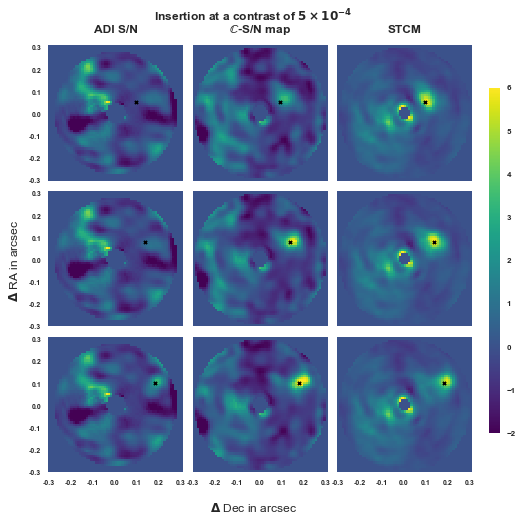

In [296]:
#This is Fig 1 of the paper
cb_titles=['S/N','$\mathcal{C}$-S/N','STC']

fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(7.6,8))
for j in range(3):
    for i in range(3):
        im = ax[j][i].pcolormesh(plt_order[j][i+1],cmap='viridis',vmin=-2,vmax=6)
        ax[j][i].set_aspect('equal', 'box')
        #cb=plt.colorbar(im,ax=ax[j][i],fraction=0.046, pad=0.04,orientation='vertical')
        #cb.ax.set_title(cb_titles[i])
        #cb.ax.tick_params(labelsize=6)
        ax[j][i].set_xticks(np.arange(0,70,10))
        ax[j][i].set_yticks(np.arange(0,70,10))
        ax[j][i].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        ax[j][i].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        ax[j][i].scatter(arrow_tups[j][0],arrow_tups[j][1],marker='x',color='k',s=10)
cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6])
cb1=fig.colorbar(ax[0][0].collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.tick_params(labelsize=8)
    #ax.set(xlim=(0,60),ylim=(0,60))
#grid = plt.GridSpec(3, 3)
#create_subtitle(fig, grid[0 ,::], 'separation of $\\approx 2.3$ FWHM',y=0.95,fontsize=10)
#create_subtitle(fig, grid[1,::], 'separation of $\\approx 3.3$ FWHM',y=0.95,fontsize=10)
#create_subtitle(fig, grid[2,::], 'separation of $\\approx 4.3$ FWHM',y=0.95,fontsize=10)
ax[0][0].set_title('ADI S/N',fontweight='bold',y=1.05)
ax[0][1].set_title('$\mathbb{C}$-S/N map',fontweight='bold',y=1.05)
ax[0][2].set_title('STCM',fontweight='bold',y=1.05)
#fig.text(0.4,0.88,'Separation $\\approx 2.3$ FWHM',fontsize=9)
#fig.text(0.4,0.625,'Separation $\\approx 3.3$ FWHM',fontsize=9)
#fig.text(0.4,0.375,'Separation $\\approx 4.3$ FWHM',fontsize=9)
fig.suptitle("Insertion at a contrast of $5\\times10^{-4}$",fontweight='bold',fontsize=12,y=0.94)
fig.supxlabel("$\Delta$ Dec in arcsec",y=0.06)
fig.supylabel("$\Delta$ RA in arcsec",y=0.5,x=0.05)
fig.subplots_adjust(wspace=0.07,hspace=0.02)

# Compute patches and read in patchea corresponding the $C_{FC}$ and $C_{N}$

In [27]:
prefix = "../data/patches/"
h1_patches = open_fits(prefix+"H1_seq_training_cont_1e-03_rad_22.0_theta_120.00.fits") #C_fc

Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)


In [29]:
h0_patches = open_fits(prefix+"initial_h0_fov11.fits")#C_N
                       

Fits HDU-0 data successfully loaded. Data shape: (270, 83, 20, 11, 11)


In [8]:
t1 = h1_patches[50,0::,:,:]
t2 =h0_patches[33,50,::,:,:]

In [9]:
t1.shape

(20, 11, 11)

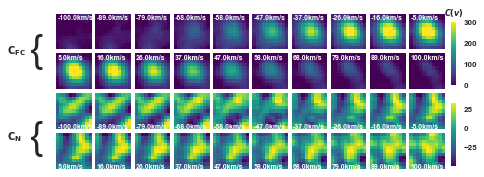

In [293]:
#this is Fig 3 of the paper
vels = np.linspace(-100,100,20)
fig, axs = plt.subplots(4,10,sharex=True,sharey=True,tight_layout=False,figsize=(8,8))

for j in range(0,2):
    for i in range(0,10):
        im= axs[j][i].pcolormesh(t1[i+(j*10)],cmap='viridis',vmin=0,vmax=300)
        axs[j][i].set_aspect('equal', 'box')
        #cb=plt.colorbar(im,ax=axs[j][i],fraction=0.046, pad=0.04,orientation='vertical')
        axs[j][i].set_xticks(np.arange(0,11,5))
        axs[j][i].set_yticks(np.arange(0,11,5))
        
        axs[j][i].set_xticklabels(["","",""],fontsize=10)
        axs[j][i].set_yticklabels(["","",""],fontsize=10)
        axs[j][i].text(0.3,9,str(np.round(vels[i+(j*10)],0))+"km/s",c='w',fontsize=7)
        #axs[j][i].subplots.subplots_adjust(hspace=0.0)
#cb=plt.colorbar(im,ax=axs[0][-1],orientation='vertical')
cbar_ax = fig.add_axes([0.81, 0.51, 0.01, 0.11])
#fig.colorbar(im, cax=cbar_ax)
#im = collections[0]
cb1=fig.colorbar(axs[0][9].collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_title("$C(v)$",fontsize=8,y=0.998)
for j in range(2,4):
    for i in range(0,10):
        im = axs[j][i].pcolormesh(t2[i+9*(j-2)],cmap ='viridis')
        axs[j][i].set_aspect('equal', 'box')
        axs[j][i].text(0.3,0.01,str(np.round(vels[i+((j-2)*10)],0))+"km/s",c='w',fontsize=7)
#draw_brace(axs[0][0],10,[-1,-1],'H1',text_pos=[-3,-2],rotate=True)
#draw_brace(axs[2][0],10,[-1,-1],'H0',text_pos=[-3,-2],rotate=True)
cbar_ax2 = fig.add_axes([0.81, 0.37, 0.01, 0.11])
cb2=fig.colorbar(axs[2][9].collections[0], cax=cbar_ax2,orientation='vertical')
cb2.ax.tick_params(labelsize=8)

fig.text(0.08,0.55,"{",fontsize=40,fontweight='normal')
fig.text(0.04,0.565,"$\\rm{C_{FC}}$",fontsize=10,fontweight='normal')
fig.text(0.08,0.40,"{",fontsize=40,fontweight='normal')
fig.text(0.04,0.415,"$\\rm{C_{N}}$",fontsize=10,fontweight='normal')
fig.subplots_adjust(wspace=0.1,top=0.95,bottom=0.05,hspace=-0.9,right=0.8)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig_2_dec2023_aligned.png",dpi=400)

# Compute the detection map and FP and TP in the data

In [6]:
filename = "fitsfiles_vel/cnn_detmap_5e-04_21.0_180.00.fits"
detmap_cnn = open_fits(filename)#[5:55,5:55]
filename_sodinn = "fitsfiles_vel/sodinn_detmap_5e-04_21.0_180.00.fits"
detmap_sodinn = open_fits(filename_sodinn)#[5:55,5:55]
filename_stim = "fitsfiles/stim_detmap_5e-04_21.0_180.00.fits"
detmap_stim = open_fits(filename_stim)#[5:55,0:55]
filename_rf = "fitsfiles_vel/rf_detmap_5e-04_21.0_180.00.fits"
detmap_rf = open_fits(filename_rf)#[5:55,0:55]
rad = float(filename.split('/')[-1].split('_')[3])
theta = float(filename.split('/')[-1].split('_')[4].split('.')[0])
cont = float(filename.split('/')[-1].split('_')[2])
y_pos = frame_center(detmap_cnn)[0]+rad*np.sin(np.deg2rad(theta))
x_pos = frame_center(detmap_cnn)[0] +rad*np.cos(np.deg2rad(theta))
#detmap_cnn = 

Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)


In [7]:
try:
    thresh_cnn = np.linspace(0.09,0.9999,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds = thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=3)
except AttributeError:
    thresh_cnn = np.linspace(0.01,0.95,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds=thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=1)
try:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.99,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.95,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
try:
    thresh_rf=np.linspace(0.01,0.99,10)
    res_rf = compute_binary_map(detmap_rf, 
                                    thresholds=thresh_rf,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    thresh_rf=np.linspace(0.01,0.7,10)
    res_rf = compute_binary_map(detmap_rf, 
                                    thresholds=thresh_rf,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)

In [8]:
thresh_stim =np.linspace(1.3,6.0,10)
res_stim = compute_binary_map(detmap_stim,thresholds=thresh_stim,
                              fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                             max_blob_fact=4)

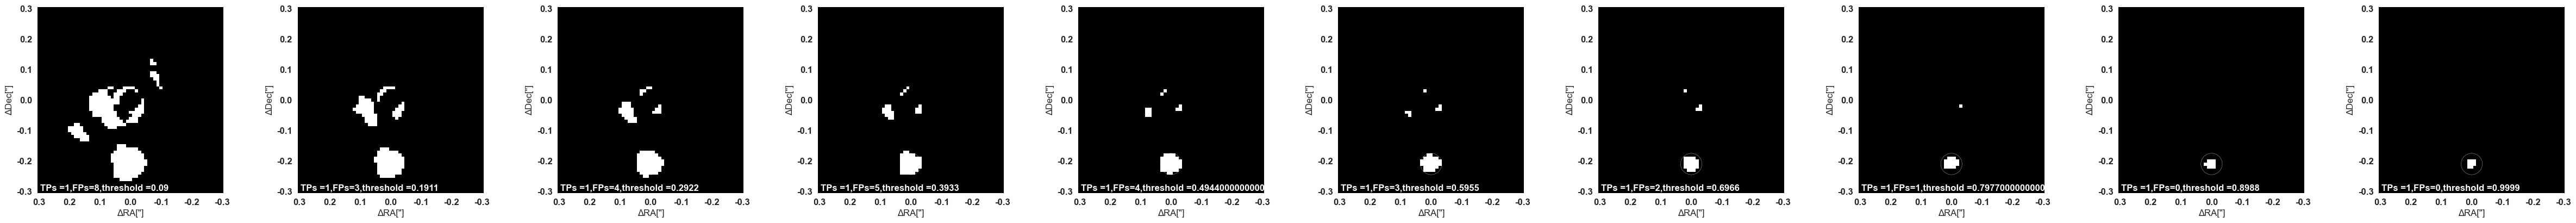

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [8, 3, 4, 5, 4, 3, 2, 1, 0, 0]


In [9]:
obj = res_stim
labs = tuple(["TPs ={0},FPs={1},threshold ={2}".format(o1,o2,o3) for o1,o2,o3 in zip(obj[0],obj[1],thresh_cnn)])
plot_frames(tuple(obj[2]),rows=1,
            ang_scale=True,ang_ticksep=10,circle=(y_pos,x_pos),circle_radius=3.5,
            cmap='gray',
           label=labs,
           colorbar=False)
print(obj[0],obj[1])

In [10]:

detmaps = [detmap_stim,detmap_cnn,detmap_sodinn]

In [11]:
from matplotlib import colors
pmaps=[]
tps=[]
fps=[]
ths=[]
for i in [3,5,7,9]:
    val = obj[2][i]
    tps.append(obj[0][i])
    fps.append(obj[1][i])
    ths.append(thresh_stim[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=7,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps.append(pmap)
#plt.pcolormesh(pmap,cmap =custom_cmap)
#plot_frames(pmap,cmap=custom_cmap)
#plt.colorbar()
 #plt.scatter(all_pos[int(i)][1],all_pos[int(i)][0],marker='o',c='k')

In [12]:
pmaps_cnn=[]
tps_cnn=[]
fps_cnn=[]
ths_cnn=[]
for i in [3,5,7,9]:
    val = res_cnn[2][i]
    tps_cnn.append(res_cnn[0][i])
    fps_cnn.append(res_cnn[1][i])
    ths_cnn.append(thresh_cnn[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=8,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps_cnn.append(pmap)

In [13]:
pmaps_sodinn=[]
tps_sodinn=[]
fps_sodinn=[]
ths_sodinn=[]
for i in [3,5,7,9]:
    val = res_sodinn[2][i]
    tps_sodinn.append(res_sodinn[0][i])
    fps_sodinn.append(res_sodinn[1][i])
    ths_sodinn.append(thresh_cnn[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=7,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps_sodinn.append(pmap)

In [1499]:
thresh_cnn

array([0.09  , 0.1911, 0.2922, 0.3933, 0.4944, 0.5955, 0.6966, 0.7977,
       0.8988, 0.9999])

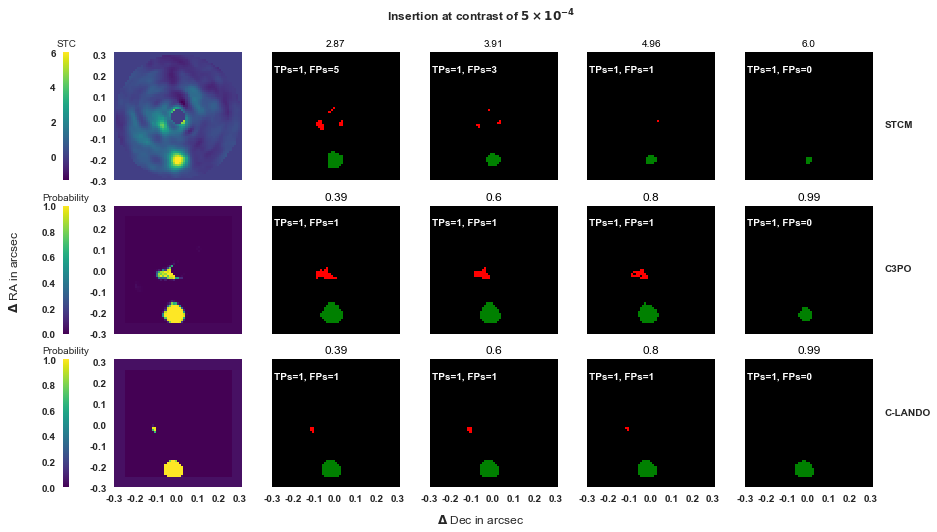

In [26]:
#Fig 4 of the paper
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
fig,axs = plt.subplots(3,len(pmaps)+1,sharey=True,sharex=True,figsize=(14,8))
#grid = plt.GridSpec(3, len(pmaps)+1)
bbox_props = dict(boxstyle="Round", fc="salmon", ec='k', alpha=0.4,pad=0.0001,x=0.01)
cb_titles =['STC','Probability','Probability']
#create_subtitle(fig, grid[0 ,::], 'Thresholded maps',y=0.95,fontsize=16)
#create_subtitle(fig, grid[0 ,::], 'STCM',y=0.85,fontsize=14)
#create_subtitle(fig, grid[1,::], 'C3PO',y=0.83, fontsize=14)
#create_subtitle(fig, grid[2,::], 'C-LANDO',y=0.83,fontsize=14)
#create_subtitle(fig, grid[0,0],'Detection maps',y=0.95,fontsize=16)
for i in range(3):
    if(i==0):
        vmax=6
        #vmin = 0
    else:
        vmax=1.0
    im = axs[i][0].pcolormesh(detmaps[i],cmap='viridis',vmax=vmax)#,vmin=vmin)
    axs[i][0].set_aspect('equal','box')
    axs[i][0].set_xticks(np.arange(0,70,10))
    axs[i][0].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[i][0].set_yticks(np.arange(0,70,10))
    axs[i][0].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[i][0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
   # axs[i][0]= divider.new_vertical(size = '100%', pad = 0.1)
    cbaxes = axs[i][0].inset_axes([-0.4, 0.0, 0.05,1.0])
    cb = plt.colorbar(im,ax=axs[i][0],fraction=0.046, pad=0.01,cax=cbaxes,orientation='vertical')
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.tick_params(labelsize=10)
    
    cb.ax.set_title(cb_titles[i],fontsize=10)
    #cb.ax.set_xticks(fontsize=8)
    #cb.ax.set_yticklabels(["{:.1}".format(i) for i in cb.get_ticks()],fontsize=8)
legend_elements =[Line2D([0], [0], marker='o', color='k', label='FP',markerfacecolor='red'),
                         Line2D([0], [0], marker='o', color='k', label='TP',markerfacecolor='green')]
#fig.legend(handles=legend_elements)
for k in range(1,len(pmaps)+1):
    i=k-1
    if(tps[i]==0):
        cmap=colors.ListedColormap(['black','red'])
    else:
        cmap=custom_cmap
    axs[0][k].pcolormesh(pmaps[i],cmap=cmap)
    axs[0][k].set_aspect('equal','box')
    axs[0][k].text(1,52,"TPs={0}, FPs={1}".format(tps[i],fps[i]),c='w',fontsize=10)
    #create_subtitle(fig, grid[0,k],'Threshold = {0:.1f}'.format(np.round(ths[i],1)),y=0.83)
    axs[0][k].set_xticks(np.arange(0,70,10))
    axs[0][k].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[0][k].set_yticks(np.arange(0,70,10))
    axs[0][k].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[0][k].set_title("{0}".format(np.round(ths[i],2)),c='k',fontsize=10)
    axs[1][k].pcolormesh(pmaps_cnn[i],cmap=custom_cmap)
    axs[1][k].set_aspect('equal','box')
    axs[1][k].text(1,52,"TPs={0}, FPs={1}".format(tps_cnn[i],fps_cnn[i]),c='w',fontsize=10)
    #create_subtitle(fig, grid[1,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[1][k].set_xticks(np.arange(0,70,10))
    axs[1][k].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    #axs[1][k].t(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='k')
    ths_cnn[-1] =0.99
    axs[1][k].set_title("{0}".format(np.round(ths_cnn[i],2)),c='k',fontsize=12)
    axs[2][k].pcolormesh(pmaps_sodinn[i],cmap=custom_cmap)
    axs[2][k].set_aspect('equal','box')
    axs[2][k].text(1,52,"TPs={0}, FPs={1}".format(tps_sodinn[i],fps_sodinn[i]),c='w',fontsize=10)
    axs[2][k].set_title("{0}".format(np.round(ths_cnn[i],2)),c='k',fontsize=12)

    #create_subtitle(fig, grid[2,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[2][k].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    #axs[2][k].text(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='w')
fig.text(0.9,0.75,'STCM')
fig.text(0.9,0.5,'C3PO')
fig.text(0.9,0.25,'C-LANDO')
#l=axs[0][1].legend(handles=legend_elements,loc='out')
#for text in l.get_texts():
 #   text.set_color("white")
fig.suptitle("Insertion at contrast of $5\\times10^{-4}$",fontweight='bold',fontsize=12,y=0.96)
fig.supxlabel("$\Delta$ Dec in arcsec",y=0.06)
fig.supylabel("$\Delta$ RA in arcsec",y=0.5,x=0.03)
plt.subplots_adjust(hspace=0.2,wspace=0.05)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/Fig3_Mar2024_referee.png",dpi=400)
#https://vip.readthedocs.io/en/latest/_modules/vip_hci/metrics/roc.html?highlight=compute_binary_map#

In [157]:
i

3

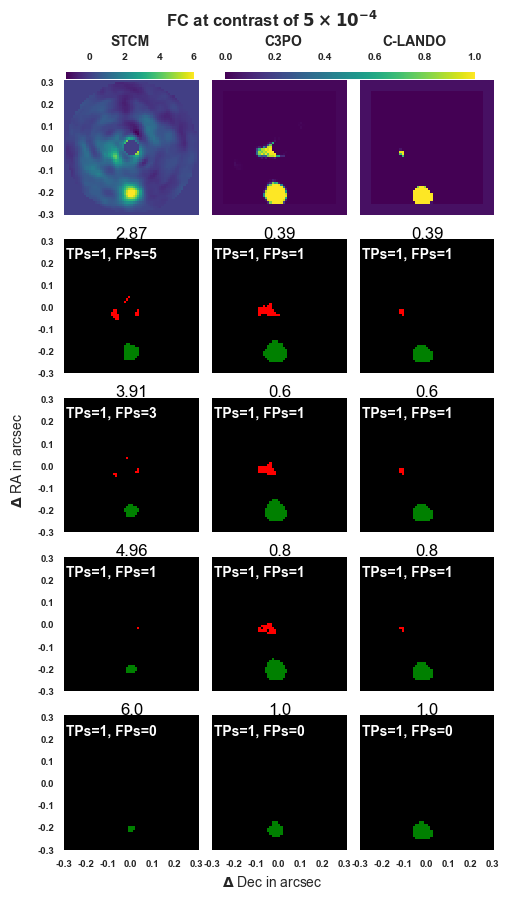

In [1955]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
fig,axs = plt.subplots(len(pmaps)+1,3,sharey=True,sharex=True,figsize=(5.7,10.0))
#grid = plt.GridSpec(3, len(pmaps)+1)
bbox_props = dict(boxstyle="Round", fc="salmon", ec='k', alpha=0.4,pad=0.0001,x=0.01)
cb_titles =['STC','Probability','Probability']
#create_subtitle(fig, grid[0 ,::], 'Thresholded maps',y=0.95,fontsize=16)
#create_subtitle(fig, grid[0 ,::], 'STCM',y=0.85,fontsize=14)
#create_subtitle(fig, grid[1,::], 'C3PO',y=0.83, fontsize=14)
#create_subtitle(fig, grid[2,::], 'C-LANDO',y=0.83,fontsize=14)
#create_subtitle(fig, grid[0,0],'Detection maps',y=0.95,fontsize=16)
vmaxs=[6.0,1.0,1.0]
for i in range(3):
    
    im = axs[0][i].pcolormesh(detmaps[i],cmap='viridis',vmax=vmaxs[i])
    axs[0][i].set_aspect('equal','box')
    if(i==0):
        axs[0][i].set_xticks(np.arange(0,70,10))
        axs[0][i].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        axs[0][i].set_yticks(np.arange(0,70,10))
        axs[0][i].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        axs[0][i].tick_params(axis='y', which='both', labelleft=True, labelright=False)
   # axs[i][0]= divider.new_vertical(size = '100%', pad = 0.1)
cbaxes = axs[0][0].inset_axes([0.013, 1.01,0.95,0.05])
cb = plt.colorbar(axs[0][0].collections[0],ax=axs[0][0],fraction=0.046, pad=0.08,cax=cbaxes,orientation ='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.tick_params(labelsize=7.5)

cbaxes = axs[0][1].inset_axes([0.05*(1+1), 1.01,1.85,0.05])
cb = plt.colorbar(axs[0][1].collections[0],ax=axs[0][1],fraction=0.046, pad=0.08,cax=cbaxes,orientation ='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.tick_params(labelsize=7.5)
    
    #cb.ax.set_title(cb_titles[i],fontsize=8)
    #cb.ax.set_xticks(fontsize=8)
    #cb.ax.set_yticklabels(["{:.1}".format(i) for i in cb.get_ticks()],fontsize=8)
fig.text(0.25,0.918,'STCM',va='center',ha='center')
fig.text(0.52,0.918,'C3PO',va='center',ha='center')
fig.text(0.75,0.918,'C-LANDO',va='center',ha='center')
legend_elements =[Line2D([0], [0], marker='o', color='k', label='FP',markerfacecolor='red'),
                         Line2D([0], [0], marker='o', color='k', label='TP',markerfacecolor='green')]
#fig.legend(handles=legend_elements)
for k in range(1,len(pmaps)+1):
    i=k-1
    if(tps[i]==0):
        cmap=colors.ListedColormap(['black','red'])
    else:
        cmap=custom_cmap
    axs[k][0].pcolormesh(pmaps[i],cmap=cmap)
    axs[k][0].set_aspect('equal','box')
    axs[k][0].text(1,52,"TPs={0}, FPs={1}".format(tps[i],fps[i]),c='w')
    #create_subtitle(fig, grid[0,k],'Threshold = {0:.1f}'.format(np.round(ths[i],1)),y=0.83)
    axs[k][0].set_xticks(np.arange(0,70,10))
    axs[k][0].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][0].set_yticks(np.arange(0,70,10))
    axs[k][0].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][0].set_title("{0}".format(np.round(ths[i],2)),c='k',y=0.94)
    axs[k][1].pcolormesh(pmaps_cnn[i],cmap=custom_cmap)
    axs[k][1].set_aspect('equal','box')
    axs[k][1].text(1,52,"TPs={0}, FPs={1}".format(tps_cnn[i],fps_cnn[i]),c='w')
    #create_subtitle(fig, grid[1,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[k][1].set_xticks(np.arange(0,70,10))
    axs[k][1].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][1].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    #axs[1][k].t(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='k')
    axs[k][1].set_title("{0}".format(np.round(ths_cnn[i],2)),c='k',y=0.94)
    axs[k][2].pcolormesh(pmaps_sodinn[i],cmap=custom_cmap)
    axs[k][2].set_aspect('equal','box')
    axs[k][2].text(1,52,"TPs={0}, FPs={1}".format(tps_sodinn[i],fps_sodinn[i]),c='w')
    #create_subtitle(fig, grid[2,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[k][2].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][2].set_title("{0}".format(np.round(ths_sodinn[i],2)),c='k',y=0.94)
    #axs[2][k].text(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='w')
#fig.text(0.95,0.37,'STCtMs ')

#l=axs[0][1].legend(handles=legend_elements,loc='out')
for text in l.get_texts():
    text.set_color("white")
fig.suptitle("FC at contrast of $5\\times10^{-4}$",fontweight='bold',fontsize=12,y=0.95)
fig.supxlabel("$\Delta$ Dec in arcsec",y=0.07,fontsize=10)
fig.supylabel("$\Delta$ RA in arcsec",y=0.5,x=0.04,fontsize=10)
plt.subplots_adjust(hspace=0.18,wspace=0.01)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/Fig3_feb_vert.png",dpi=400)

# Fig 9 and 10

In [128]:
try:
    thresh_cnn = np.linspace(0.09,0.9999,10)
    res_cnn =compute_binary_map(mask_circle(detmap_cnn,3.5),
                            thresholds = thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=3)
except AttributeError:
    thresh_cnn = np.linspace(0.1,0.95,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds=thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=1)
detmap_sodinn = detmap_sodinn#[5:56,5:56]
y_pos = frame_center(detmap_sodinn)[0]+rad*np.sin(np.deg2rad(theta))
x_pos = frame_center(detmap_sodinn)[0] +rad*np.cos(np.deg2rad(theta))
try:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.9999,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.85,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)

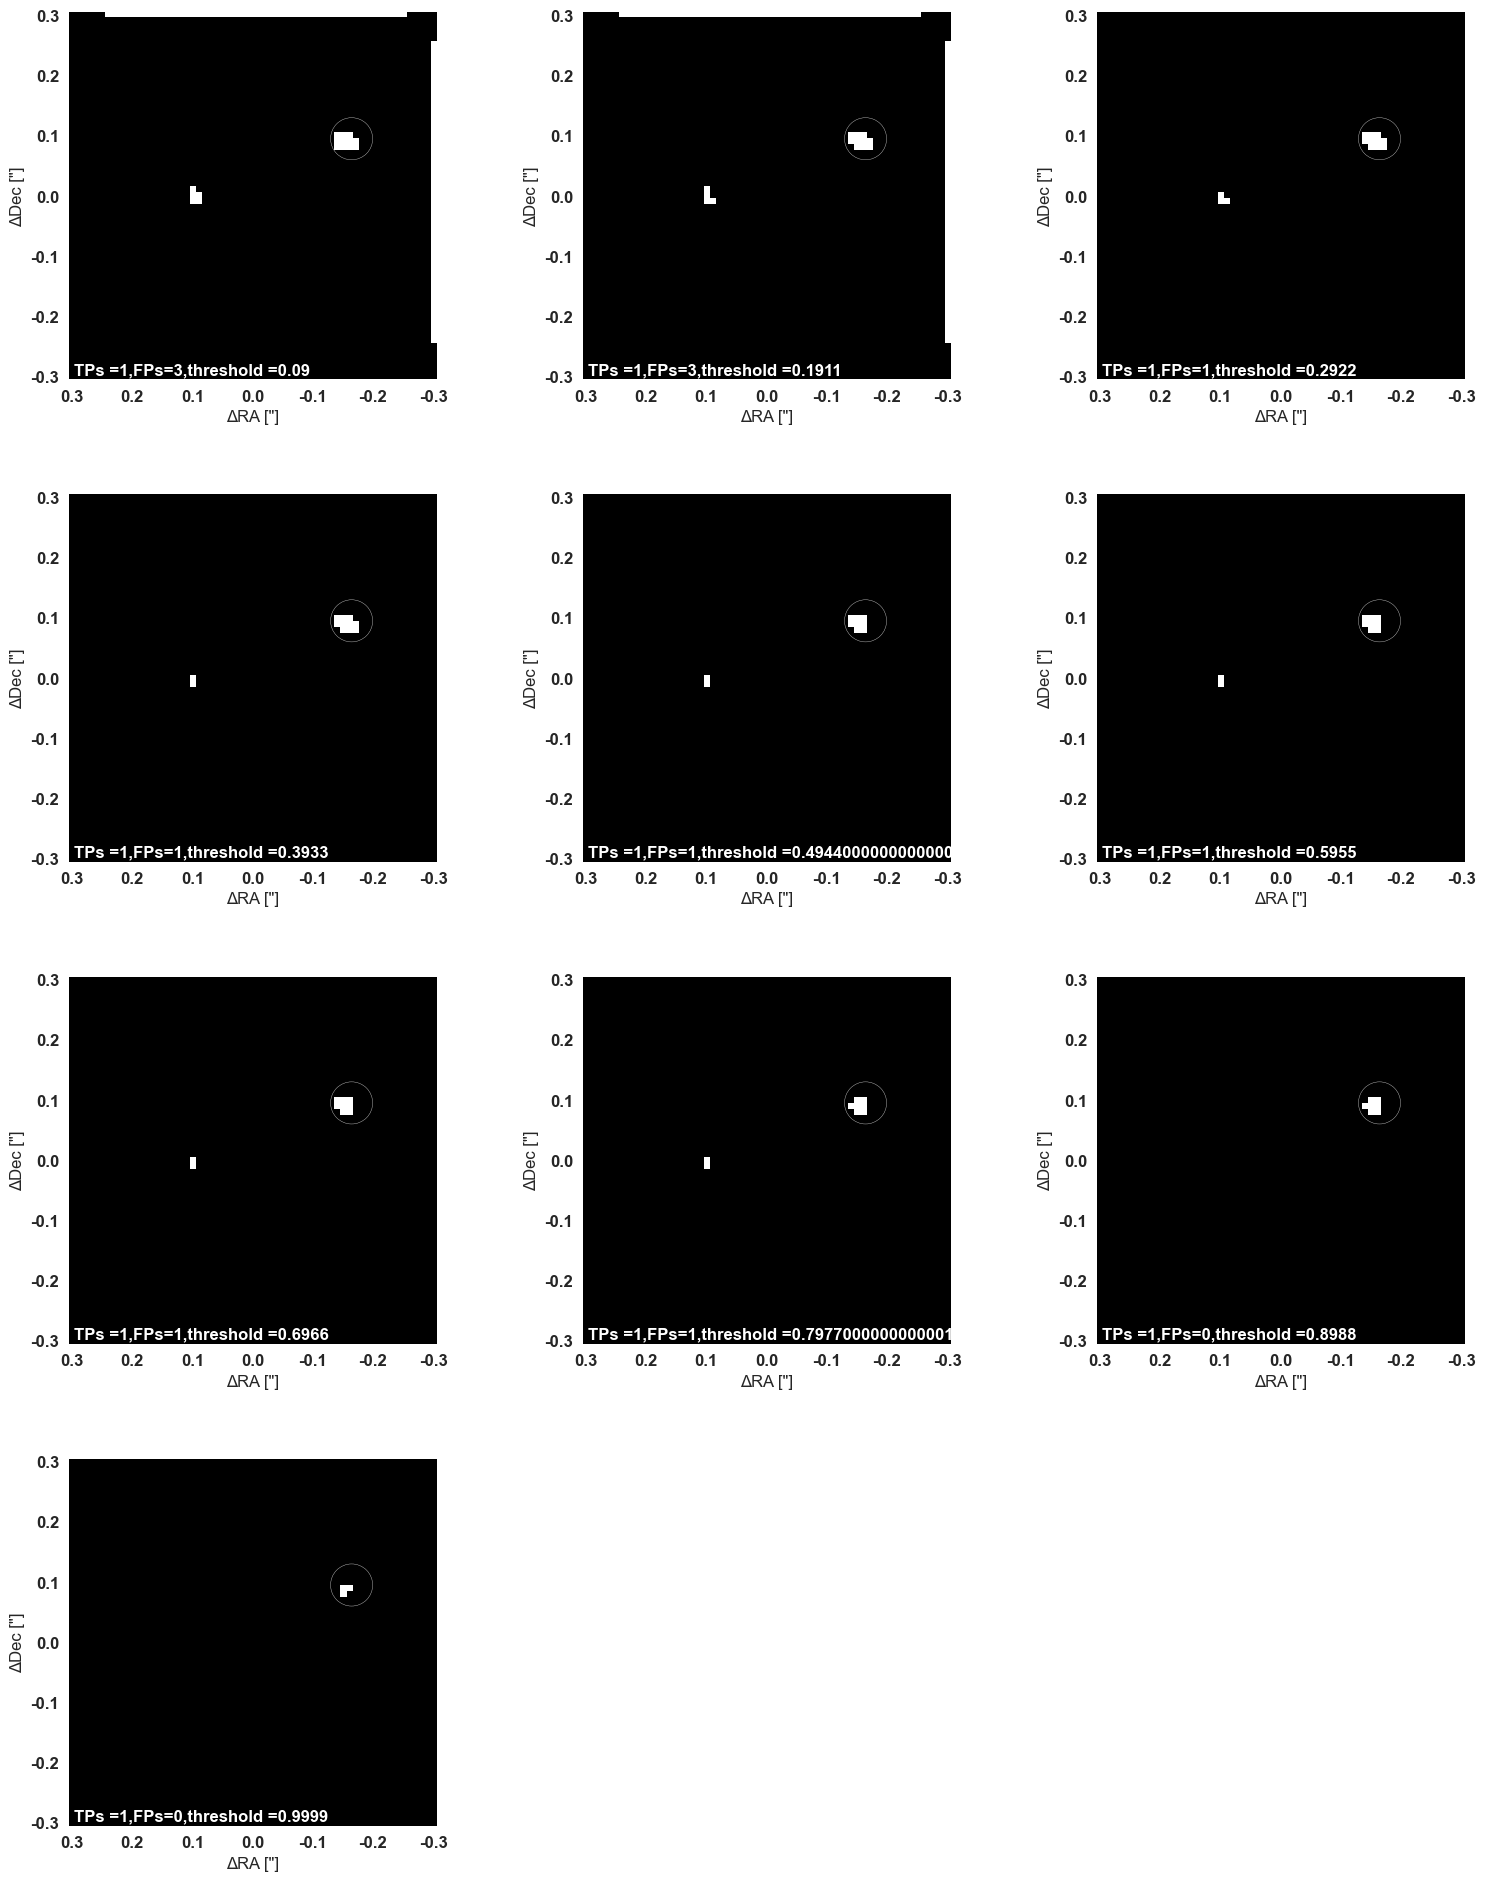

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [3, 3, 1, 1, 1, 1, 1, 1, 0, 0]


In [129]:
obj = res_sodinn
labs = tuple(["TPs ={0},FPs={1},threshold ={2}".format(o1,o2,o3) for o1,o2,o3 in zip(obj[0],obj[1],thresh_cnn)])
plot_frames(tuple(obj[2]),rows=4,
            ang_scale=True,ang_ticksep=10,circle=(y_pos,x_pos),circle_radius=3.5,
            cmap='gray',
           label=labs,
           colorbar=False)
print(obj[0],obj[1])

## New fig 6 (ROC)

In [27]:
mask = 3.5
start_pix =9.0
end_pix =13.0
C_low = 1e-04
C_high = 3e-04
tpr_stim_vel = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_sodinn_vel = open_fits("stats_roc_runs_vel/tpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_cnn_vel = open_fits("stats_roc_runs_vel/tpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_stim = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_sodinn_vel = open_fits("stats_roc_runs_vel/fpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn_vel = open_fits("stats_roc_runs_vel/fpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_stim_vel = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_cnn_vel = open_fits("stats_roc_runs_vel/thresh_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_sodinn_vel = open_fits("stats_roc_runs_vel/thresh_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [37]:
mask = 3.5
#start_pix =19.0
#end_pix =23.0
C_low = [5e-04,3e-04,1e-04]
C_high = [7e-04,5e-04,3e-04]
start_pixs=[19,14,9]#[9,14,19]
end_pixs = [23,18,13]#[13,18,23]
all_tps=[]
all_fps=[]
all_thresh=[]
for c in range(3):
    tprs=[]
    fps=[]
    thresh=[]
    for i in range(3):
        tprs_peralgo=[]
        fps_peralgo=[]
        thresh_peralgo=[]
        for string in ['stim','cnn','sodinn']:
            tprs_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            fps_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            thresh_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
        tprs.append(tprs_peralgo)
        fps.append(fps_peralgo)
        thresh.append(thresh_peralgo)
    all_tps.append(tprs)
    all_fps.append(fps)
    all_thresh.append(thresh)

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0

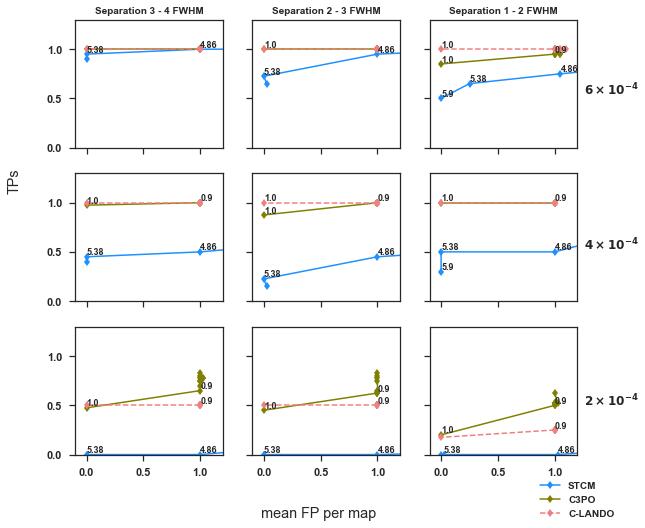

In [45]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("notebook", font_scale=1.0)

fig,axs = plt.subplots(3,3,sharey=True,sharex=True,figsize=(9,8))
labels =['STCM','C3PO','C-LANDO']
colors = ['dodgerblue','olive','lightcoral']
linestyles = ['solid','solid','dashed']
for row in range(len(all_fps)):
    for col in range(3):
        for j in range(3):
            axs[row][col].plot(all_fps[row][col][j],all_tps[row][col][j],label = labels[j],marker='d',
                               color=colors[j],
                               linestyle = linestyles[j])


            axs[0][col].set_title("Separation {0:d} - {1:d} FWHM".format(int(start_pixs[col]/4.8),
                                                                         int(end_pixs[col]/4.8)),fontweight='bold',fontsize=10)
            axs[row][col].set_xlim(-0.1,1.2)
            axs[row][col].set_ylim(0,1.3)
            start = 8
            if(j ==0):
                start = 7
            else:
                start = 8
            for sing in range(start,10):
            
                #if()
                txt = axs[row][col].text(all_fps[row][col][j][sing],all_tps[row][col][j][sing]+sep,
                              '{0:s}'.format(str(np.round(all_thresh[row][col][j][sing],2))),fontsize=9)
                plt.draw()
                if any(txt.get_window_extent().overlaps(t.get_window_extent()) for t in axs[row][col].texts[:-1]):
                    txt.remove() 
                
            #axs[row][col].set_yscale('log')
handles, labels = axs[1][1].get_legend_handles_labels()

fig.legend(handles=handles,labels=labels,loc=(0.83,0.01),fontsize=10)
fig.text(0.91,0.75,'$6\\times10^{-4}$',fontsize=12)
fig.text(0.91,0.48,'$4\\times10^{-4}$',fontsize=12)
fig.text(0.91,0.21,'$2\\times10^{-4}$',fontsize=12)
fig.supxlabel("mean FP per map")
fig.supylabel("TPs",x=0.02,y=0.6)
#fig.text(0.1,0.05,"({0:s}-{1:s})".format(str(np.round(all_thresh[0][0][0][7],2)),
                                         # str(np.round(all_thresh[0][0][0][9],2))),color='dodgerblue')
#fig.text(0.1,0.03,"({0:s}-{1:s})".format(str(np.round(all_thresh[0][0][1][8],2)),
                                         #str(np.round(all_thresh[0][0][1][9],2))),color='olive')
fig.savefig("/mnt/diskss/home/rnath/NathRanga2024/Paper/fig4_Apr2024_referee.png",dpi=400)
#axs[i][j].set_aspect('equal','box')str(np.round(all_thresh[0][0][0][9],3))

In [1403]:
all_thresh[-1][1][:]

[array([1.2      , 1.7222222, 2.2444444, 2.7666667, 3.288889 , 3.8111112,
        4.3333335, 4.8555555, 5.3777776, 5.9      ], dtype=float32),
 array([0.09 , 0.191, 0.292, 0.393, 0.494, 0.595, 0.696, 0.797, 0.898,
        0.999], dtype=float32),
 array([0.09 , 0.191, 0.292, 0.393, 0.494, 0.595, 0.696, 0.797, 0.898,
        0.999], dtype=float32)]

# Discussions

## velocity

In [46]:
mask = 3.5
start_pix =19.0
end_pix =23.0
C_low = 3e-04
C_high = 5e-04
tpr_stim = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_sodinn = open_fits("stats_roc_runs_novel_fixedthresh/v0/tpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_cnn = open_fits("stats_roc_runs_novel_fixedthresh//tpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_stim = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_sodinn = open_fits("stats_roc_runs_novel_fixedthresh/v0/fpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:3.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn = open_fits("stats_roc_runs_novel_fixedthresh//fpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_stim_vel = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_cnn = open_fits("stats_roc_runs_novel_fixedthresh//thresh_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_sodinn = open_fits("stats_roc_runs_novel_fixedthresh//thresh_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [47]:
C_low = [3e-04,1e-04]
C_high = [5e-04,3e-04]
start_pixs=[19]#[9,14,19]
end_pixs = [23]#[13,18,23]
all_tpsnovel=[]
all_fpsnovel=[]
all_threshnovel=[]
for c in range(len(C_low)):
    tprsnovel=[]
    fpsnovel=[]
    threshnovel=[]
    for i in range(len(start_pixs)):
        tprs_peralgonovel=[]
        fps_peralgonovel=[]
        thresh_peralgonovel=[]
        for string in ['cnn','sodinn']:
            if(string =='sodinn'):
                tprs_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/v0/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                fps_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/v0/fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                thresh_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/v0/thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            else:
                tprs_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                fps_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh//fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                thresh_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh//thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
        tprsnovel.append(tprs_peralgonovel)
        fpsnovel.append(fps_peralgonovel)
        threshnovel.append(thresh_peralgonovel)
    all_tpsnovel.append(tprsnovel)
    all_fpsnovel.append(fpsnovel)
    all_threshnovel.append(threshnovel)

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [210]:
fpf_cnn=[282., 158., 150., 152., 150., 150.,  75.,  75.,  75.,  75.,] 
fpf_sodinn=[225., 225., 225., 224., 148., 142.,  75.,  75.,  76.,  75.,] 
fpf_rf =[145.,  77.,  75.,  75., 156., 150., 150., 150., 225.,  75.,]
#tpf_stim=[67., 51., 50., 50., 49., 45., 34., 26., 25., 23.,]
tpf_cnn=[55., 54., 52., 50., 50., 50., 50., 50., 50., 42.,] 
tpf_sodinn=[51., 52., 50., 49., 48., 46., 46., 46., 46., 37.,] 

In [49]:
mask = 3.5
#start_pix =19.0
#end_pix =23.0
C_low = [3e-04,1e-04]
C_high = [5e-04,3e-04]
start_pixs=[19]#[9,14,19]
end_pixs = [23]#[13,18,23]
all_tps=[]
all_fps=[]
all_thresh=[]
for c in range(len(C_low)):
    tprs=[]
    fps=[]
    thresh=[]
    for i in range(len(start_pixs)):
        tprs_peralgo=[]
        fps_peralgo=[]
        thresh_peralgo=[]
        for string in ['stim','cnn','sodinn']:
            tprs_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            fps_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            thresh_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
        tprs.append(tprs_peralgo)
        fps.append(fps_peralgo)
        thresh.append(thresh_peralgo)
    all_tps.append(tprs)
    all_fps.append(fps)
    all_thresh.append(thresh)

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [185]:
len(all_fps)

2

Text(0.5, 1.0, 'mean Contrast $<4\\times10^{-4}$ between $3-4$ FWHM ')

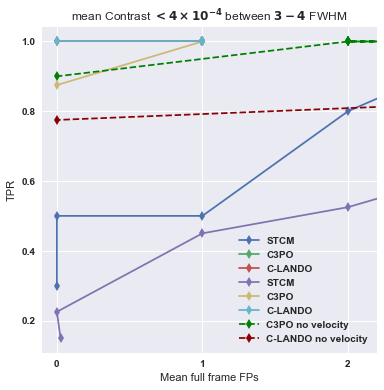

In [214]:
fig,axs = plt.subplots(1,1,figsize=(6,6))
labels =['STCM','C3PO','C-LANDO']
for row in range(len(all_fps)):
    for j in range(len(labels)):
        axs.plot(all_fps[row][][j],all_tps[0][row][j],label = labels[j],marker='d')
#axs.plot(np.asarray(fpf_cnn)/75,np.asarray(tpf_cnn)/75,c='green',ls='--',marker='d',
 #        label ='C3PO no velocity')
axs.plot(fpr_cnn,tpr_cnn,marker='d',c='green',ls='--',
         label ='C3PO no velocity')
#axs.plot(np.asarray(fpf_sodinn)/75,np.asarray(tpf_sodinn)/75,c='darkred',ls='--',marker='d',
 #       label ='C-LANDO no velocity')
axs.plot(fpr_sodinn,tpr_sodinn,marker='d',c='darkred',ls ='--',
         label ='C-LANDO no velocity')
#axs.plot(fpr_rf,tpr_rf,marker='d',c='teal',ls ='--',
 #        label ='C-LANDO no velocity')
axs.set_xlim(-0.1,2.2)
axs.set_xticks([0,1,2])
plt.xlabel("Mean full frame FPs")
plt.ylabel("TPR")
plt.legend()
plt.title("mean Contrast $<4\\times10^{-4}$ between $3-4$ FWHM ")
#fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig6_disc_23Feb.png",dpi=400)

In [179]:
tpr_sodinn,fpr_sodinn

(array([0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825,
        0.775], dtype=float32),
 array([4.  , 3.  , 3.  , 3.  , 3.  , 3.  , 3.  , 3.  , 2.95, 0.  ],
       dtype=float32))

In [226]:

(C_low[row]+C_high[row])/2

0.00039999999999999996

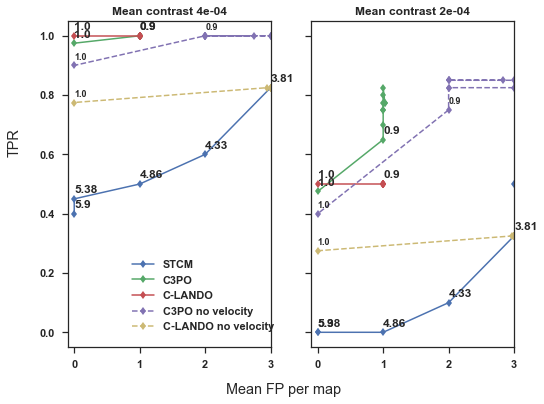

In [78]:
fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(8,6))
#fig.ax.set_xlim(-0.1,2.1)
labels =['STCM','C3PO','C-LANDO']
for row in range(len(all_fps)):
    for col in range(1):
        for j in range(len(labels)):
            axs[row].plot(all_fps[row][col][j],all_tps[row][col][j],label = labels[j],marker='d')
            #axs[row].set_title("Separation {0:d} - {1:d} FWHM".format(int(start_pixs[col]/4.8),int(end_pixs[col]/4.8)))
            axs[row].set_title("Mean contrast {0:1.0e}".format((C_low[row]+C_high[row])/2),fontweight='bold')
            #axs[row].set_xlim(-0.1,1.2)
            if j==0:
                start =5
            else:
                start =8
            for sing in range(start,10):
                axs[row].text(all_fps[row][col][j][sing],all_tps[row][col][j][sing]+0.02,
                              '{0:s}'.format(str(np.round(all_thresh[row][col][j][sing],2))))
            #axs[row][col].set_xscale('log')
handles, leg_labels = axs[1].get_legend_handles_labels()
#fig.ax.set_xlim(-0.1,2.1)
labels =['C3PO no velocity','C-LANDO no velocity']
for row in range(len(all_fpsnovel)):
        for j in range(len(labels)):
            axs[row].plot(all_fpsnovel[row][col][j],all_tpsnovel[row][col][j],label = labels[j],marker='d',ls='--')
            #axs[row].set_title("Separation {0:d} - {1:d} FWHM".format(int(start_pixs[col]/4.8),int(end_pixs[col]/4.8)))
            #axs[row].set_xlim(-0.1,2)
           
            for sing in range(8,10):
                #axs[row].text(all_fpsnovel[row][col][j][sing]+0.04,all_tpsnovel[row][col][j][sing]+0.02,
                 #             '{0:s}'.format(str(np.round(all_threshnovel[row][col][j][sing],2))))
                txt = axs[row].text(all_fpsnovel[row][col][j][sing],all_tpsnovel[row][col][j][sing]+sep,
                              '{0:s}'.format(str(np.round(all_threshnovel[row][col][j][sing],2))),fontsize=9)
                plt.draw()
                if any(txt.get_window_extent().overlaps(t.get_window_extent()) for t in axs[row].texts[:-1]):
                    txt.remove() 
                
                
            

            #axs[row][col].set_xscale('log')
#fig.ax.set_xlim(-0.1,2.1)
h,l = axs[1].get_legend_handles_labels()
axs[0].set_xlim(-0.1,3)
axs[0].set_xticks([0,1,2,3])
#ig.legend()
fig.legend(bbox_to_anchor=(0.5, 0.35),handles=h,labels=l)
#fig.text(0.002,0.75,'$6\\times10^{-4}$')
#fig.text(0.88,0.48,'Separation\n3-4 FWHM',)
#fig.text(0.002,0.21,'$2\\times10^{-4}$')
fig.supxlabel("Mean FP per map")
fig.supylabel("TPR",x=0.02,y=0.6)
fig.savefig("/mnt/diskss/home/rnath/NathRanga2024/Paper/Fig6_April2024_referee.png",dpi=400)

In [65]:
texts

[Text(0.0, 0.9399999761581421, '1.0')]

In [228]:
len(all_fpsnovel)

1

In [194]:
help(fig.legend)

Help on method legend in module matplotlib.figure:

legend(*args, **kwargs) method of matplotlib.figure.Figure instance
    Place a legend on the figure.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to these three different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        fig.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        fig.legend()
    
    Specific lines can be excluded from the automatic legend elem

In [ ]:
pl

## Spatial dimension

In [271]:
prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Training_vel/Training/"
h1_patches_lc = open_fits(prefix+"H1patches/H1_seq_training_cont_5e-04_rad_22.0_theta_120.00.fits")
h1_patches_hc = open_fits(prefix+"H1patches/H1_seq_training_cont_1e-04_rad_22.0_theta_120.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)
Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)


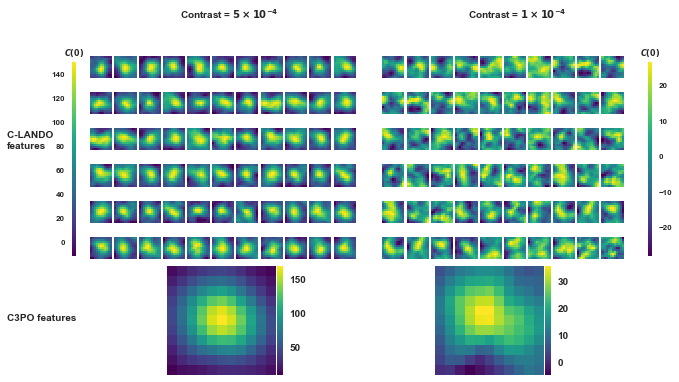

In [277]:
fig = plt.figure(figsize=(10,6
                         ))
rows = 9
columns =23
grid = plt.GridSpec(rows, columns,hspace=0.0001,wspace=0.1)
for i in range(6):
    for j in range(11):
   #fig.add_subplot(4,6,i)
            
        temp_cube = j+i*7
        ax = plt.subplot(grid[i,j])
        if(j ==0):
            ax.set_yticklabels("")
            #ax.set_xticklabels("")
        if(i ==5):
            ax.set_xticks([0,10])
            ax.set_xticklabels("")
            ax.set_yticklabels("")
        else:
            ax.set_xticklabels("")
            ax.set_yticklabels("")
        plt.pcolormesh(h1_patches_lc[temp_cube,10,:,:],cmap='viridis')
        ax.set_aspect('equal', 'box')
cbar_ax = fig.add_axes([0.1, 0.4, 0.005, 0.45])
cb1=fig.colorbar(ax.collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_title('$C(0)$',fontsize=8)
#fig.add_subplot(4,6,([20,21,22,23]))
ax = plt.subplot(grid[6:10,3:8])
plt.pcolormesh(np.mean(h1_patches_lc,axis=0)[10,:,:],cmap='viridis')
ax.set_xticklabels("")
ax.set_yticklabels("")
plt.colorbar(fraction=0.046, pad=0.01)
ax.set_aspect('equal', 'box')
for i in range(6):
    for j in range(12,22):
   #fig.add_subplot(4,6,i)
        temp_cube = j+i*7
        ax = plt.subplot(grid[i,j])
        plt.pcolormesh(h1_patches_hc[temp_cube,10,:,:],cmap='viridis')
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.set_aspect('equal', 'box')
#fig.add_subplot(4,6,([20,21,22,23]))
cbar_ax = fig.add_axes([0.9, 0.4, 0.005, 0.45])
cb1=fig.colorbar(ax.collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.yaxis.set_ticks_position('right')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_title('$C(0)$',fontsize =8)
ax= plt.subplot(grid[6:10,14:19])
plt.pcolormesh(np.mean(h1_patches_hc,axis=0)[10,:,:],cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.01)
ax.set_aspect('equal', 'box')
ax.set_xticklabels("")
ax.set_yticklabels("")
fig.text(0.25,0.95,"Contrast = $5\\times10^{-4}$")
fig.text(0.65,0.95,"Contrast = $1\\times10^{-4}$")
fig.text(0.01,0.65,'C-LANDO \nfeatures')
fig.text(0.01,0.25,'C3PO features')
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig5_disc_dec2023.png",dpi=400)